In [1]:
#Import all libraries needed for this assigment

from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from PIL import Image
from os import path

import sys 
import matplotlib 
%matplotlib inline
import os
import csv
import glob
import folium
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Creating the .csv files for each category.

In [2]:
#Making csv files for each category , from .txt files.


#Directory Locations for each subject

LocationSport         = '/home/dimitris/Data_Mining/Project2/fulltext/data/sport/'

LocationTech          = '/home/dimitris/Data_Mining/Project2/fulltext/data/tech/'

LocationBusiness      = '/home/dimitris/Data_Mining/Project2/fulltext/data/business/'

LocationEntertainment = '/home/dimitris/Data_Mining/Project2/fulltext/data/entertainment/'

LocationPolitics      = '/home/dimitris/Data_Mining/Project2/fulltext/data/politics/'

#We create a dictionary for each subject

alldf = {}

#All Locations in one list

LocationList = [ LocationSport, LocationTech, LocationBusiness, LocationEntertainment, LocationPolitics ]


#This function is converting txt files into csv.
def createCSV(Location):

    title       = []
    content     = []
    realContent = []

    lines = open(Location, encoding="utf8" , errors="ignore").read().splitlines()

    for line in range (len(lines)):
        if (line==0):

            title.append(lines[line])
        
        elif(lines[line]!=''):
            content.append(lines[line])

    valString = ''.join(content)

    realContent.append(valString)
    
    BabyDataSet = list(zip(title,realContent))
    return BabyDataSet


#Function to concatenate all csv into one, for each subject.
def concatCSV(Location):

    finaldf = []
    
    for filename in os.listdir(Location):

    
        if filename.endswith(".txt"): 
        
            subdf = createCSV(Location + filename)
        
            finaldf.append(subdf[0])
    
    return finaldf



#We fullfil the dictionary with each csv file
for Location in range(len(LocationList)):
    
    subdf = concatCSV(LocationList[Location])
    
    finaldf =  pd.DataFrame( data = subdf , columns=['Title','Content'])
    
    if (Location==0):
        
        alldf["sport"] = finaldf
        
        alldf["sport"] = alldf["sport"].assign(category='sport')
    
    elif (Location==1):

        alldf["tech"] = finaldf
        
        alldf["tech"] = alldf["tech"].assign(category='tech')
    
    elif (Location==2):
        
        alldf["business"] = finaldf
        
        alldf["business"] = alldf["business"].assign(category='business')
        
    elif (Location==3):
        
        alldf["entertainment"] = finaldf
        
        alldf["entertainment"] = alldf["entertainment"].assign(category='entertainment')
        
    else:
        
        alldf["politics"] = finaldf
        
        alldf["politics"] = alldf["politics"].assign(category='politics')

alldf["tech"].head(100)



,Title,Content,category
0,Viewers to be able to shape TV,Imagine editing Titanic down to watch just you...,tech
1,Search sites get closer to users,Search sites want to get to know you better.No...,tech
2,Speak easy plan for media players,Music and film fans will be able to control th...,tech
3,Napster offers rented music to go,"Music downloading, for those that have rejecte...",tech
4,Technology gets the creative bug,The hi-tech and the arts worlds have for some ...,tech
...,...,...,...
95,Blogger grounded by her airline,A US airline attendant is fighting for her job...,tech
96,Microsoft makes anti-piracy move,Microsoft says it is clamping down on people r...,tech
97,Concern over RFID tags,Consumers are very concerned about the use of ...,tech
98,Video phone help for deaf people,Deaf people who prefer to communicate using Br...,tech


### 1: Creating WordClouds for each subject (A simple but yet functional way).

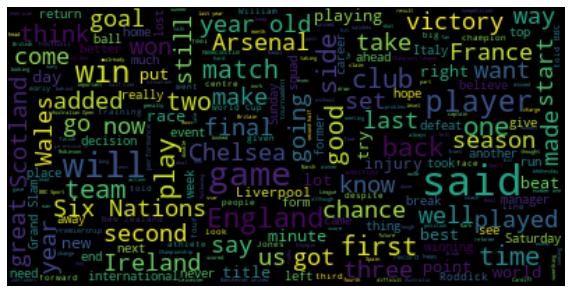

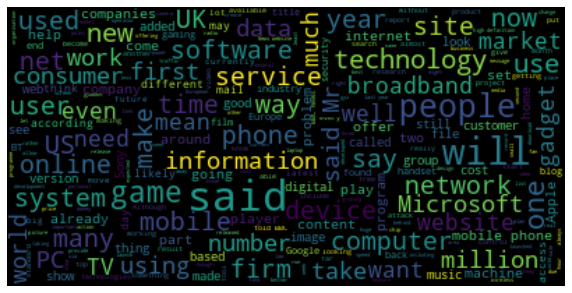

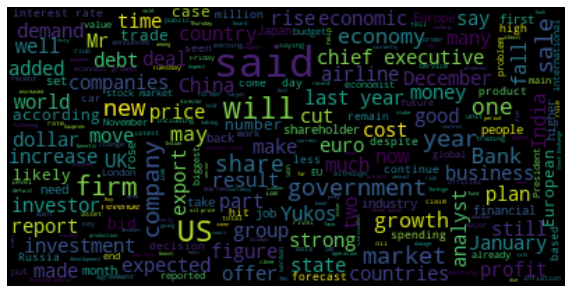

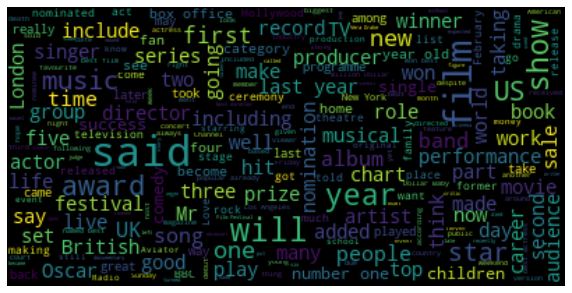

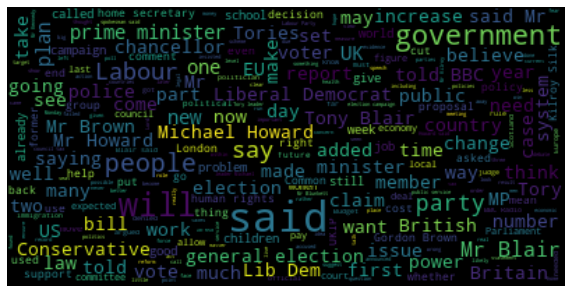

In [3]:
names = ["sport" , "tech" , "business" , "entertainment" , "politics"]

for name in names:
    
    text=""
    for i in range(len(alldf[name])):
        
        text += alldf[name].Content[i]
    
    wordcloud = WordCloud(max_font_size=30, max_words=250, background_color="black",stopwords=STOPWORDS).generate(text)
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()


### 2: Classification and Evaluation. We are going to see some popular models of classification , such as Support Vector Machines, Random Forests, Naive Bayes, K-Nearest Neighbor. At the end, we are going to evaluate the accuracy of each method with 10-fold Cross Validation. Also, we are going to use BoW and tf-idf , for converting words into numbers.

In [12]:
#Import all the libraries that we need to for classification.

from sklearn import svm                                                  #Library for Support Vector Machines
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC , SVC
from sklearn.model_selection import GridSearchCV                         #To find the best parameters

from sklearn.feature_extraction.text import CountVectorizer              #BoW
from sklearn.feature_extraction.text import TfidfVectorizer              #tf-idf

from sklearn.model_selection import train_test_split, cross_val_score    #To divide our data evenly
from sklearn import preprocessing                                        #Create numeric categories using the LabelEncoder and fit-trasnsform pipeline
from sklearn.model_selection import KFold                                #For multiclasses, through loop, instead of cross_val
from sklearn.preprocessing import label_binarize

#To evaluate the: Precision,Recall and F-Measure

from scipy import spatial                                                     #For KNN
from collections import Counter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity



In [10]:
#Here we'll have all the functions we are going to use for these methods.

def sumWords(field):
    
    text=""
    
    for i in range(len(field)):
        
        text += field.Content[i]
        
    return text


pd.set_option('display.max_rows', None)



def Word_Vectorizer(X_train, Y_train, X_test, Y_test, method):
    
    le = preprocessing.LabelEncoder()
    le.fit(Y_train)
    
    #Y_train and Y_test form now and then , will have numeric values instead of strings
    #Same for X_train and X_test

    Y_train = le.transform(Y_train)
    Y_test  = le.transform(Y_test)

    vectorizer = method()

    X_train = vectorizer.fit_transform(X_train)
    X_test  = vectorizer.transform(X_test)

    return X_train, Y_train, X_test, Y_test

def classify(classifier, X_train, Y_train, X_test):
    
    classifier.fit(X_train ,Y_train)

    Y_pred = classifier.predict(X_test)

    return Y_pred
    
def print_Scores(Y_pred,Y_test):
    
    acc  = 0
    prec = 0 
    rec  = 0
    f1   = 0
    
    length = len(Y_pred)
    
    for i in range(len(Y_pred)):
        
        acc  += accuracy_score(Y_test[i], Y_pred[i])
        prec += precision_score(Y_test[i], Y_pred[i], average="weighted")
        rec  += recall_score(Y_test[i], Y_pred[i], average="weighted")
        f1   += f1_score(Y_test[i], Y_pred[i], average="weighted")
    
    acc  = acc/length
    prec = prec/length
    rec  = rec/length
    f1   = f1/length
    
    print("Accuracy-Score for 10-Fold-val is: ", acc)
    print("Precision-Score for 10-Fold-val is: ", prec)
    print("Recall-Score for 10-Fold-val is: ", rec)
    print("F1-Score for 10-Fold-val is: ", f1 , '\n')

    
    
def print_TTS(Y_pred,Y_test):

    print("Accuracy for TTS Method: " ,accuracy_score(Y_test,Y_pred))
    print("Precision for TTS Method: " ,precision_score(Y_test,Y_pred, average='weighted'))
    print("Recall for TTS Method: ", recall_score(Y_test,Y_pred, average='weighted'))
    print("F1 for TTS Method: ", f1_score(Y_test,Y_pred, average='weighted') , "\n\n")
          
        
def TenFCross(X_train,Y_train,classifier):
    
    X = X_train
    Y = Y_train
    Y_pred = []
    Y_testList = []

    skf = KFold(n_splits=10)
    KFold(n_splits=10,random_state=None, shuffle=False)

    for train_index, test_index in skf.split(X , Y):
       
#     print('TRAIN:', train_index, 'TEST:', test_index)
    
        xTrain = X[train_index]
        xTest  = X[test_index]
    
        yTrain = Y[train_index]
        yTest  = Y[test_index] 

        Y_pred.append(classify(clf_svm,xTrain,yTrain,xTest))
        Y_testList.append(yTest)
    
    print_Scores(Y_pred,Y_testList)  
    
def plot_categories(X_train, y_train):
    
    X = X_train
    y = y_train

    lda = LinearDiscriminantAnalysis(n_components=2)
    X_r2 = lda.fit(X.toarray(), y).transform(X.toarray())

    target_names = combined_csv["category"].unique()

    plt.figure()
    colors = ['navy', 'turquoise', 'darkorange', 'red' ,'black']


    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
        plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of combined_csv dataset')
    plt.show()

    

In [6]:
#Converting words into numbers with BoW and tf-idf Methods.


#Creating a big CSV with all the categories.

combined_csv = pd.concat([alldf[cat] for cat in alldf ])

combined_csv = combined_csv.reset_index();

# X_train, Y_train, X_test, Y_test = Word_Vectorizer(content_train, category_train, content_test, category_test, CountVectorizer)


# Bow & Tf-Idf Methods:

### Support Vector Machines, Random Forests, Naive Bayes.

In [7]:
#Now, for tf-idf Method:

#(SMV):

VecMethods = [CountVectorizer, TfidfVectorizer]

for i in range(len(VecMethods)):

    print("For vectorizing method: ", VecMethods[i], "We have the follows:\n \n")
    
    print("For Support Vector Machines we have:\n")

    #Simple SMV without any parameteres:

    print("1): Simple SMV, without any parameteres:")

    #1). Train,Test-Split Method:

    content_train , content_test , category_train , category_test = train_test_split(combined_csv["Content"], combined_csv["category"], test_size=0.2)

    X_train, Y_train, X_test, Y_test = Word_Vectorizer(content_train, category_train, content_test, category_test, VecMethods[i])

    clf_svm = svm.SVC()

    clf_svm.fit(X_train ,Y_train)

    Y_pred = clf_svm.predict(X_test)

    print("Accuracy for TTS Method: " ,accuracy_score(Y_test,Y_pred))
    print("Precision for TTS Method: " ,precision_score(Y_test,Y_pred, average='weighted'))
    print("Recall for TTS Method: ", recall_score(Y_test,Y_pred, average='weighted'))
    print("F1 for TTS Method: ", f1_score(Y_test,Y_pred, average='weighted') , "\n\n")


    #2). 10-Fold Cross Validation at X_train and Y_train:

    TenFCross(X_train,Y_train,clf_svm)

    print("2): SMV With different kernel parameters(Linear , rbf) and also different c and gamma values \n \n")

    y_train = Y_train
    y_test  = Y_test

    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    scores = ['precision', 'recall']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            SVC(), tuned_parameters, scoring='%s_macro' % score
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

        print("For Random Forests we have:\n")

    #1). Train,Test-Split Method:

    clf_rf = RandomForestClassifier(max_depth=2, random_state=0)

    clf_rf.fit(X_train, Y_train)
    Y_pred = clf_rf.predict(X_test)

    print_TTS(Y_pred,Y_test)

    #2). 10-Fold Cross Validation at X_train and Y_train:

    TenFCross(X_train,Y_train,clf_rf)
    
    print("For Naive Bayes we have:\n")

    #1). Train,Test-Split Method:

    clf_nb = GaussianNB()

    clf_nb.fit(X_train.toarray() ,Y_train)

    Y_pred = clf_nb.predict(X_test.toarray())

    print_TTS(Y_pred,Y_test)

    #2). 10-Fold Cross Validation at X_train and Y_train:

    TenFCross(X_train,Y_train,clf_nb)

For vectorizing method:  <class 'sklearn.feature_extraction.text.CountVectorizer'> We have the follows:
 

For Support Vector Machines we have:

1): Simple SMV, without any parameteres:
Accuracy for TTS Method:  0.9168539325842696
Precision for TTS Method:  0.9177814596560058
Recall for TTS Method:  0.9168539325842696
F1 for TTS Method:  0.9162627754138966 


Accuracy-Score for 10-Fold-val is:  0.9303370786516855
Precision-Score for 10-Fold-val is:  0.9327879498821201
Recall-Score for 10-Fold-val is:  0.9303370786516855
F1-Score for 10-Fold-val is:  0.9296415281482497 

2): SMV With different kernel parameters(Linear , rbf) and also different c and gamma values 
 

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.927 (+/-0.025) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.859 (+/-0.037) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.940 (+/-0.014) for {'C': 10, 'gamma': 0.001, '

/home/dimitris/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.048 (+/-0.001) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.048 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.048 (+/-0.001) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.048 (+/-0.001) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.960 (+/-0.010) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.048 (+/-0.001) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.971 (+/-0.016) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.960 (+/-0.010) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.975 (+/-0.018) for {'C': 1, 'kernel': 'linear'}
0.971 (+/-0.017) for {'C': 10, 'kernel': 'linear'}
0.971 (+/-0.017) for {'C': 100, 'kernel': 'linear'}
0.971 (+/-0.017) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    

# Clustering.

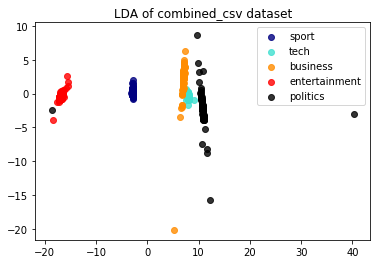

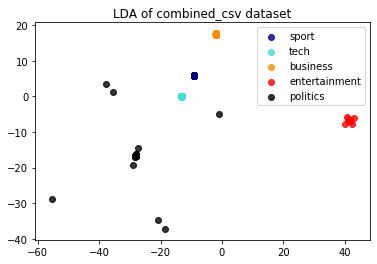

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#First for BoW, and then for Tf-idf:

for i in range(len(VecMethods)):
    
    content_train , content_test , category_train , category_test = train_test_split(combined_csv["Content"], combined_csv["category"], test_size=0.2)

    X_train, y_train, X_test, y_test = Word_Vectorizer(content_train, category_train, content_test, category_test, VecMethods[i])

    X_Norm = preprocessing.normalize(X_train)

    kmeans = KMeans(n_clusters = 5 , random_state = 0).fit(X_Norm)
    
    plot_categories(X_train, y_train)
    

In [14]:
combined_csv["category"].unique()
print(kmeans.get_params())

{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 5, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}


In [19]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import gensim

tokenized_words = content_train.apply(lambda x: x.split())

model_w2v = gensim.models.Word2Vec(
    
    tokenized_words,
    size=200,
    window=5,
    min_count=2,
    sg=1,
    hs=0,
    negative=10,
    workers=2,
    seed=34)

model_w2v.train(tokenized_words, total_examples = len(content_train),epochs=20)

(10048507, 13340160)

Σημείωση: Δεν υλοποιήθηκαν λόγω έλλειψης χρόνου και ατομικότητα της εργασίας:
    
1)KNN

2)Roc-Plots

3)Οπτικοποίηση των κειμένων με τους clusters(εμφανίστηκαν μόνο οι κατηγορίες στις οποίες ανήκουν τα κείμενα και αυτά με την μέθοδο SVD).